# Beer Demand Prediction
## About data: 
Our customer is a large beverages producer. The file contains historical weekly sales quantity, 
sales value, price and promotion data for beer products (stock keeping units - SKUs) within 1 retail 
megastore for 7 years. 
* there are 98 different products (SKUs) 
* promotion data includes 3 types of in-store promotions: promo price, promo displays and 
catalogs. The promotions are expected to increase sales (but not guaranteed). The latter 2 
types also have different sub-types as defined in the dictionary 
* the raw data has been pre-processed so there is no need for data cleaning step 
* we also collected information on significant holiday events as the sales may 
increase/decrease on or around them   
## The goal: 
* come up with the best model for demand prediction (for sales quantity) 
## Additional information: 
* please provide preferred model for demand forecast for a subset of SKUs (5-10 of them, at 
your choice) 
* feel free to construct additional features from the variables provided if it helps 
* you don’t need to use all provided features 
* this is generally time series problem 
* ideally we would like to obtain also a measure of price elasticity (sensitivity of sales to a 
measure of price change) within the forecasting model 
* please send us the results as a Jupyter notebook or in your preferred format

In [1]:
!pip install openpyxl statsmodels xgboost scikit-learn~=1.0 --user

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

Let's take a look at the data:

In [3]:
df = pd.read_excel('./demo data.xlsx')
df.head()

,product,week_no,year,month,salesQ,price,revenue,promo_price,display_1,display_2,...,catalog_3,catalog_4,time.Halloween,time.Thanksgiving,time.Christmas,time.NewYear,time.Easter,time.Memorial,time.X4thJuly,time.LabourDay
0,beer.beer_SS1,1,1,Jan,22,5.450909,119.919998,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,beer.beer_SS1,2,1,Jan,12,6.450000,77.400000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,beer.beer_SS1,3,1,Jan,11,6.490000,71.390000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,beer.beer_SS1,4,1,Jan,4,6.490000,25.960000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,beer.beer_SS1,5,1,Feb,3,6.490000,19.470000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product            35672 non-null  object 
 1   week_no            35672 non-null  int64  
 2   year               35672 non-null  int64  
 3   month              35672 non-null  object 
 4   salesQ             35672 non-null  int64  
 5   price              35672 non-null  float64
 6   revenue            35672 non-null  float64
 7   promo_price        35672 non-null  int64  
 8   display_1          35672 non-null  int64  
 9   display_2          35672 non-null  int64  
 10  catalog_1          35672 non-null  int64  
 11  catalog_2          35672 non-null  int64  
 12  catalog_3          35672 non-null  int64  
 13  catalog_4          35672 non-null  int64  
 14  time.Halloween     35672 non-null  int64  
 15  time.Thanksgiving  35672 non-null  int64  
 16  time.Christmas     356

In [5]:
df.describe()

,week_no,year,salesQ,price,revenue,promo_price,display_1,display_2,catalog_1,catalog_2,catalog_3,catalog_4,time.Halloween,time.Thanksgiving,time.Christmas,time.NewYear,time.Easter,time.Memorial,time.X4thJuly,time.LabourDay
count,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.0,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,182.500000,3.991758,12.844724,7.720754,96.536907,0.286527,0.195307,0.065093,0.001822,0.085782,0.030556,0.0,0.019231,0.019231,0.016484,0.016484,0.019231,0.019231,0.019231,0.019231
std,105.078825,1.993820,15.773870,3.939364,141.137643,0.452145,0.396443,0.246693,0.042648,0.280045,0.172114,0.0,0.137337,0.137337,0.127327,0.127327,0.137337,0.137337,0.137337,0.137337
min,1.000000,1.000000,1.000000,0.990000,1.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91.750000,2.000000,4.000000,4.990000,22.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,182.500000,4.000000,8.000000,7.070000,47.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,273.250000,6.000000,15.000000,10.990000,104.850000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,364.000000,7.000000,223.000000,30.990000,2697.969960,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see, catalog_4 consists of zeros; we can drop this column. Revenue = price * salesQ, so we can drop it too.

In [6]:
df.drop(columns=['catalog_4', 'revenue'], inplace=True)

First let's check if we can use ARIMA model. It demands stationarity, so I'll check it with KPSS test.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
def decompose_demand(df, share_type='count', samples=250, period=52):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

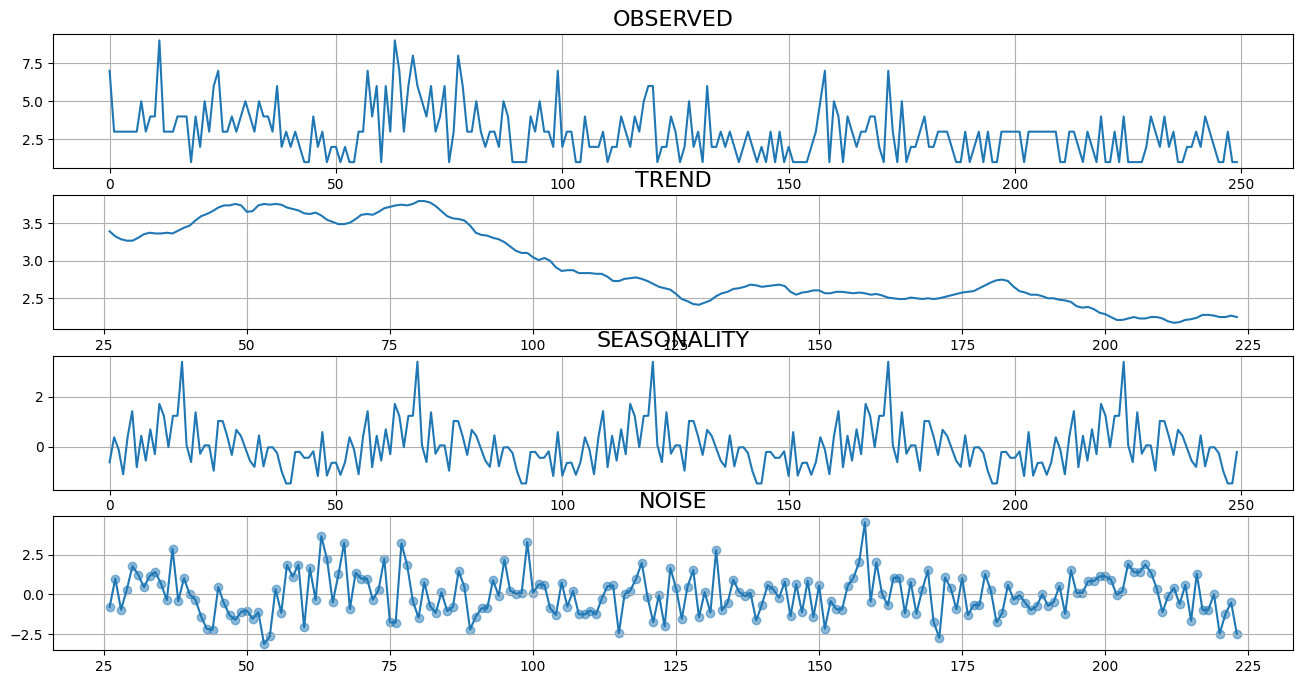

In [9]:
decompose_demand(df, 'salesQ')

In [10]:
from statsmodels.tsa.stattools import kpss

In [11]:
result_kpss_ct=kpss(df['salesQ'],regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.359517
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


D:\envs\envCKB\lib\site-packages\statsmodels\tsa\stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The p-value is 0.01. Since this value is less than .05, we reject the null hypothesis of the KPSS test. This means the time series is not trend stationary.  
We can change it by differencing:

In [12]:
df['sales_diff']=df.groupby('product')['salesQ'].diff()

In [13]:
result_kpss_ct=kpss(df['sales_diff'].dropna(),regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.067345
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


D:\envs\envCKB\lib\site-packages\statsmodels\tsa\stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The p-value is 0.1. Since this value is not less than .05, we fail to reject the null hypothesis of the KPSS test.

This means we can assume that the time series is trend stationary.

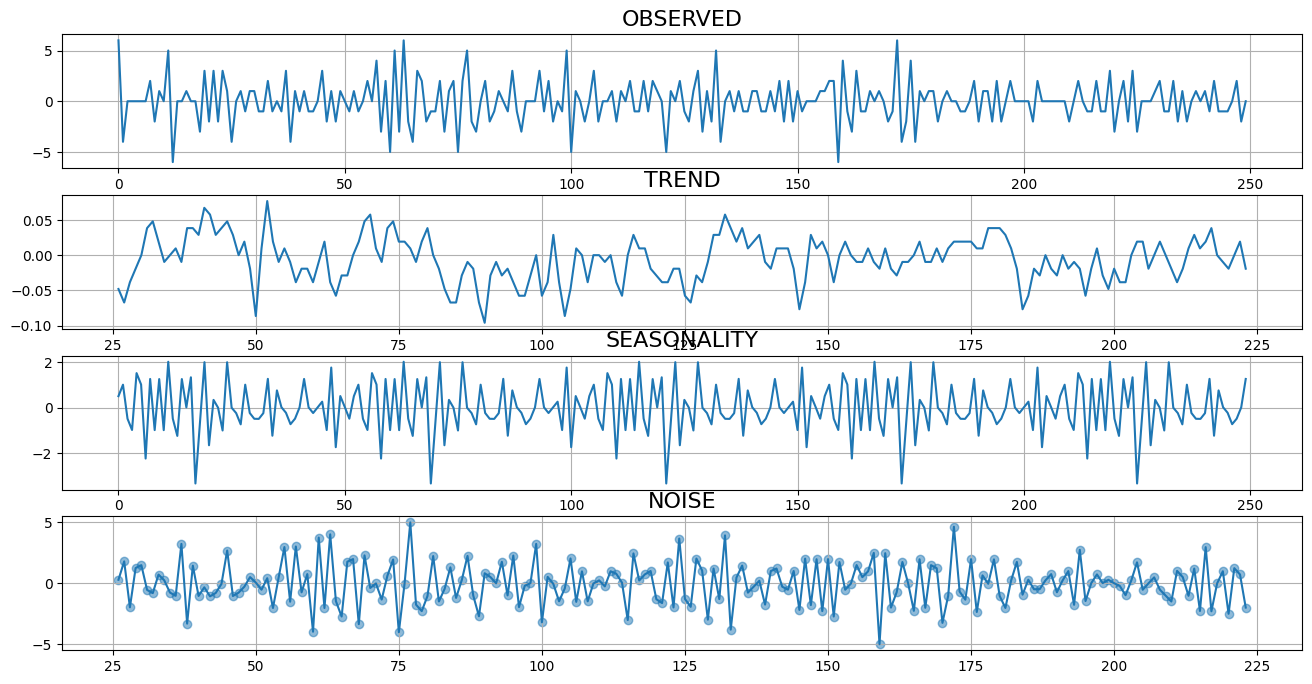

In [14]:
decompose_demand(df, 'sales_diff')

I'll plot ACF and PACF:

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

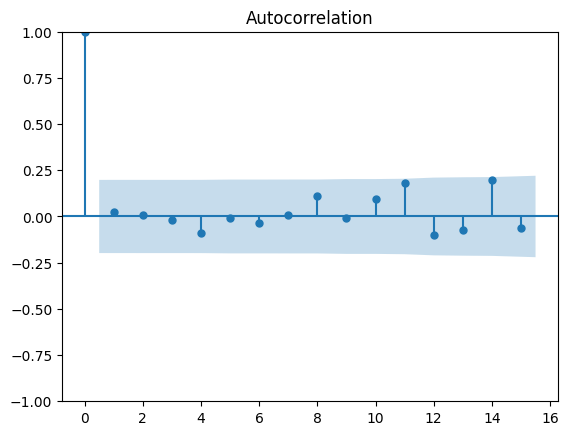

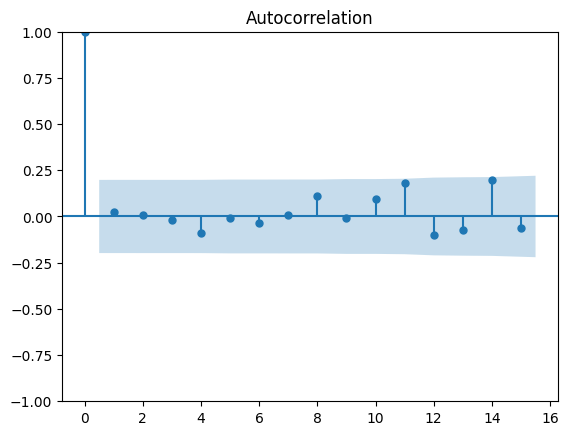

In [16]:
plot_acf(df.groupby('product')['sales_diff'].mean().dropna(), lags=15)

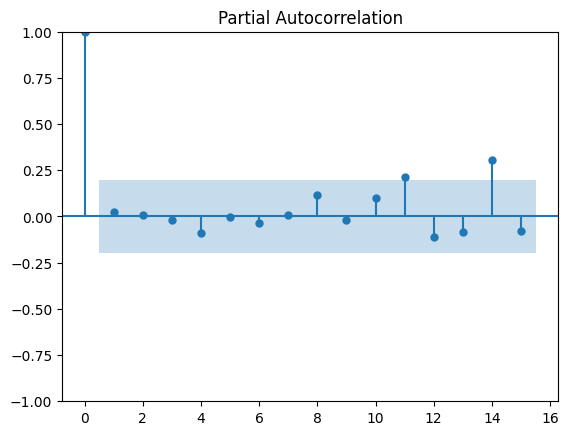

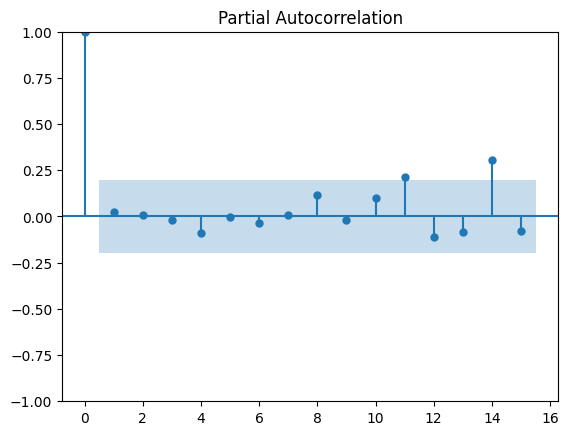

In [17]:
plot_pacf(df.groupby('product')['sales_diff'].mean().dropna(), lags=15)

They both drop instantly, so this TS is a white noise and we can't use AR or MA models. I'm gonna look into the data. 

In [18]:
df = df.drop(columns=['sales_diff'])

We need to add month as a number:

In [19]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_no'] = df['month'].map(months.index) + 1

Let's add some cyclical features:

In [20]:
df['m1'] = np.sin(df['month_no'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month_no'] * (2 * np.pi / 12))

I also want to add week number in a year; it may be relevant

In [21]:
df['week_of_year'] = (df['week_no'] - 1) % 52 + 1

I'll calculate sales for the last 10 weeks:

In [22]:
window = 10
for i in range(1, window + 1):
    df[f'sales_{i}'] = df.groupby('product').shift(i)['salesQ']

I'm also gonna add a 'price_change' column showing how price changed comparing to the previous week.

In [23]:
df['price_change'] = df['price'] - df.shift(1)['price']

In [24]:
df.head(15)

,product,week_no,year,month,salesQ,price,promo_price,display_1,display_2,catalog_1,...,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,price_change
0,beer.beer_SS1,1,1,Jan,22,5.450909,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beer.beer_SS1,2,1,Jan,12,6.450000,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999091
2,beer.beer_SS1,3,1,Jan,11,6.490000,0,0,0,0,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040000
3,beer.beer_SS1,4,1,Jan,4,6.490000,0,0,0,0,...,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,beer.beer_SS1,5,1,Feb,3,6.490000,0,0,0,0,...,11.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
5,beer.beer_SS1,6,1,Feb,11,6.090000,1,1,0,0,...,4.0,11.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,-0.400000
6,beer.beer_SS1,7,1,Feb,22,5.430000,1,1,0,0,...,3.0,4.0,11.0,12.0,22.0,NaN,NaN,NaN,NaN,-0.660000
7,beer.beer_SS1,8,1,Feb,25,6.230000,0,1,0,0,...,11.0,3.0,4.0,11.0,12.0,22.0,NaN,NaN,NaN,0.800000
8,beer.beer_SS1,9,1,Mar,4,5.990000,0,1,0,0,...,22.0,11.0,3.0,4.0,11.0,12.0,22.0,NaN,NaN,-0.240000
9,beer.beer_SS1,10,1,Mar,7,6.560000,0,0,0,0,...,25.0,22.0,11.0,3.0,4.0,11.0,12.0,22.0,NaN,0.570000


Let's check if all products have all data:

In [25]:
(df.groupby('product')['price'].count() == 364).all()

True

That's true, so every product has infomation for 364 weeks. Let's look at a few visualizations:

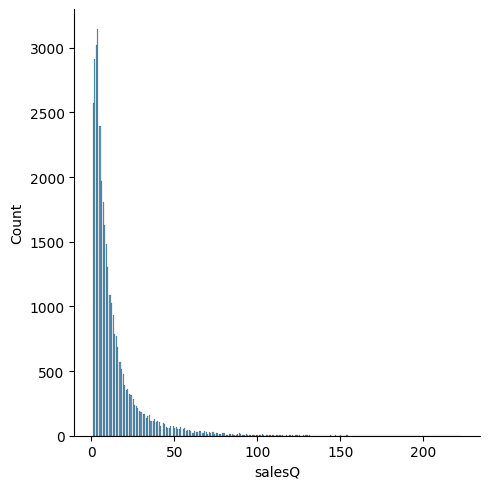

In [26]:
sns.displot(df['salesQ'])

<AxesSubplot:xlabel='salesQ'>

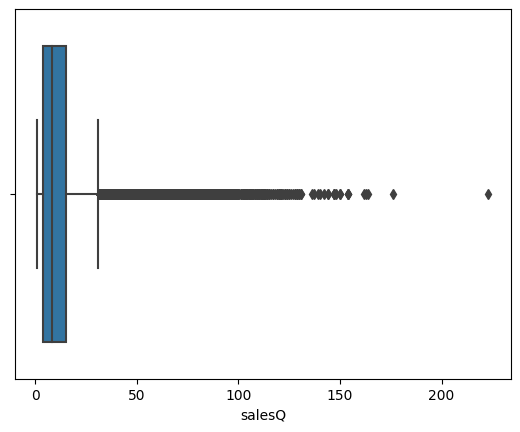

In [27]:
sns.boxplot(df['salesQ'])

<AxesSubplot:title={'center':'Mean sales and price over time'}, xlabel='week_no'>

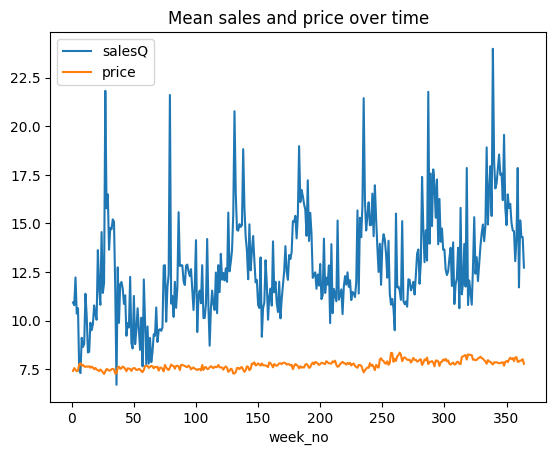

In [28]:
df.groupby(['week_no']).mean().plot(y=['salesQ', 'price'], title='Mean sales and price over time')

We can see a repeating pattern. Let's goup data by number of month and week in year:

<AxesSubplot:title={'center':'Sales and price dependency on the month'}, xlabel='month_no'>

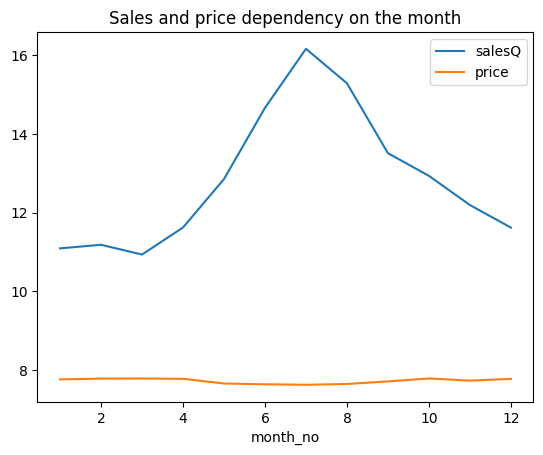

In [29]:
df.groupby(['month_no']).mean().plot(y=['salesQ', 'price'], title='Sales and price dependency on the month')

<AxesSubplot:title={'center':'Sales and price dependency on the week of year'}, xlabel='week_of_year'>

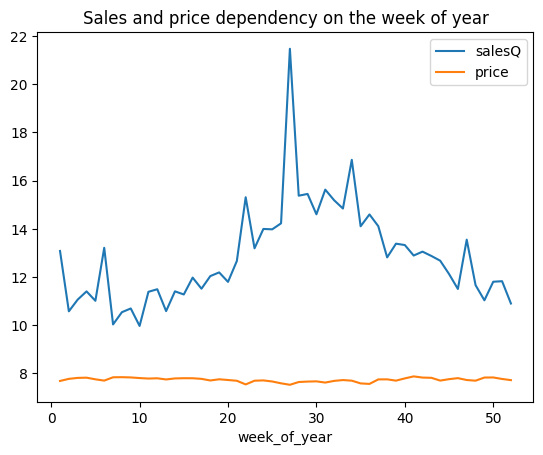

In [30]:
df.groupby('week_of_year').mean().plot(y=['salesQ', 'price'],  title='Sales and price dependency on the week of year')

There is an obvious pattern. Thus, month_no and week_of_year are important features.  
We can look at the difference of prices and sales of different SKUs:

<AxesSubplot:title={'center':'Product prices'}, xlabel='product'>

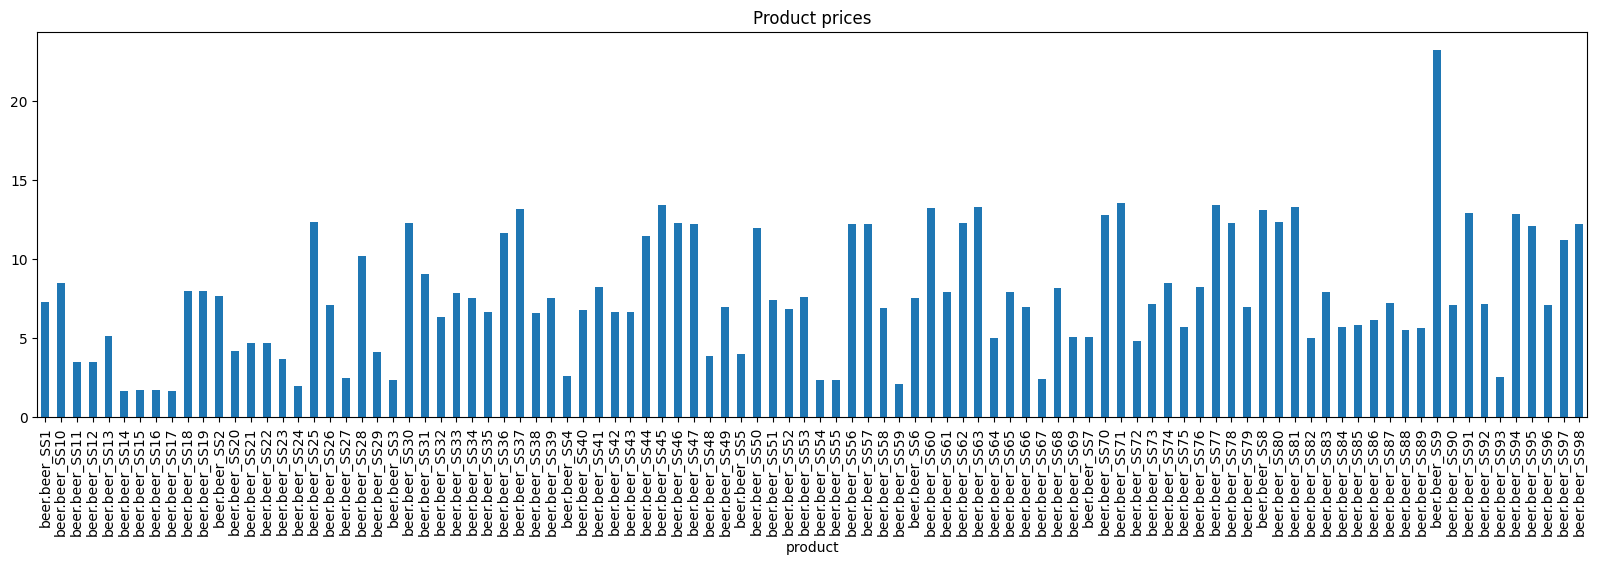

In [31]:
df.groupby('product')['price'].mean().plot(kind='bar', figsize=(20, 5), title='Product prices')

<AxesSubplot:title={'center':'Product sales'}, xlabel='product'>

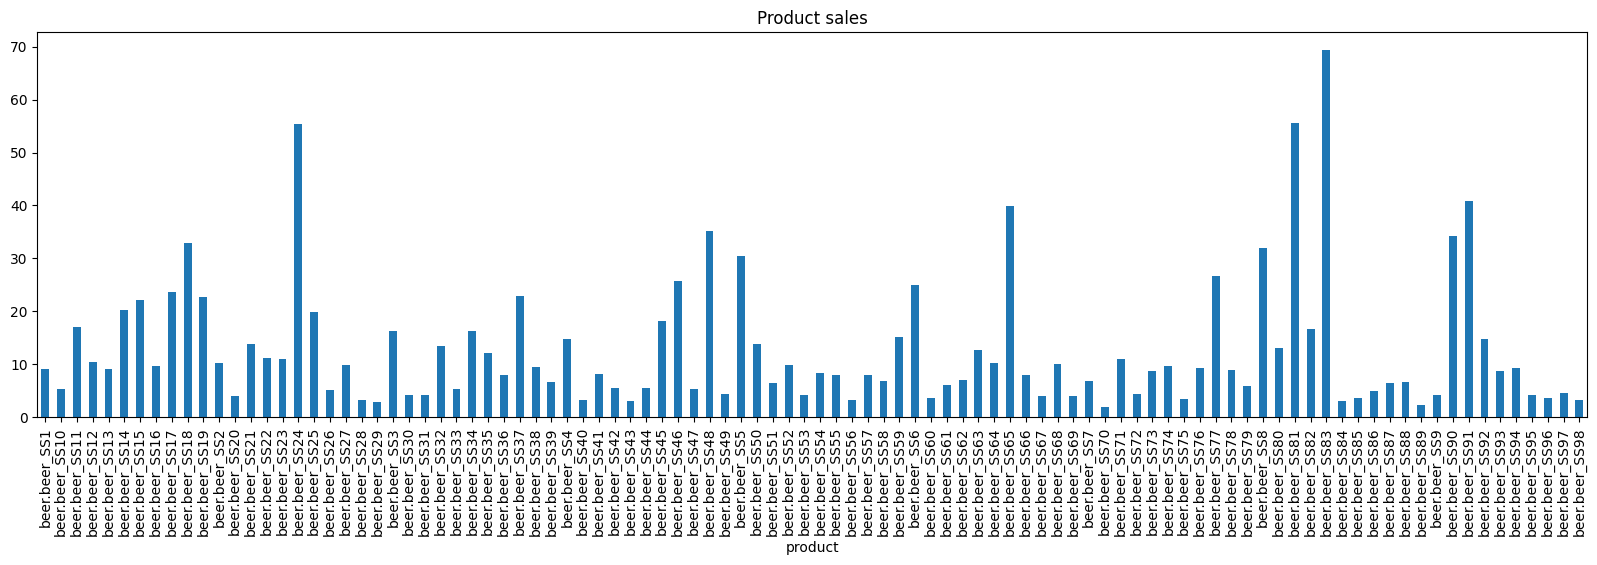

In [32]:
df.groupby('product')['salesQ'].mean().plot(kind='bar', figsize=(20, 5), title='Product sales')

Features Heatmap:

<AxesSubplot:>

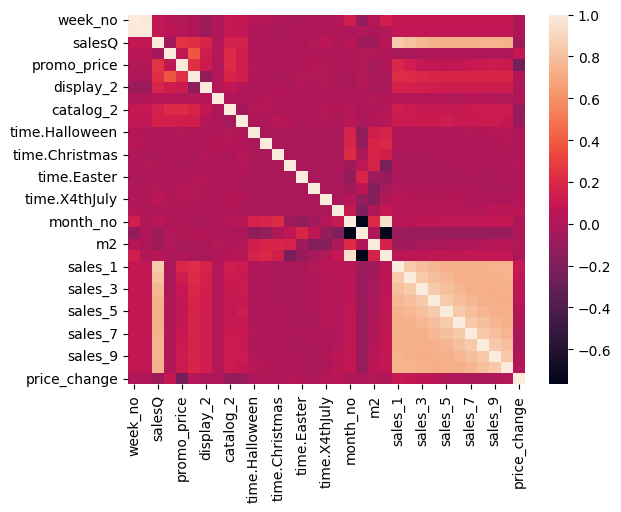

In [33]:
sns.heatmap(df.corr())

We need to put aside a subset of SKUs for the test.

In [34]:
test_products = df['product'].sample(10, random_state=1)
test_products

19947    beer.beer_SS55
619       beer.beer_SS2
4511     beer.beer_SS13
6591     beer.beer_SS19
1830      beer.beer_SS6
33691    beer.beer_SS93
26479    beer.beer_SS73
6926     beer.beer_SS20
26824    beer.beer_SS74
4115     beer.beer_SS12
Name: product, dtype: object

In [35]:
one_hot = pd.get_dummies(df['product'])
df = df.join(one_hot)
df.head()

,product,week_no,year,month,salesQ,price,promo_price,display_1,display_2,catalog_1,...,beer.beer_SS9,beer.beer_SS90,beer.beer_SS91,beer.beer_SS92,beer.beer_SS93,beer.beer_SS94,beer.beer_SS95,beer.beer_SS96,beer.beer_SS97,beer.beer_SS98
0,beer.beer_SS1,1,1,Jan,22,5.450909,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,beer.beer_SS1,2,1,Jan,12,6.450000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,beer.beer_SS1,3,1,Jan,11,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,beer.beer_SS1,4,1,Jan,4,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,beer.beer_SS1,5,1,Feb,3,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_test = df[(df['product'].isin(test_products)) & (df['week_no'] > 300)]
df_train = pd.concat([df, df_test, df_test]).drop_duplicates(keep=False)
len(df_train), len(df_test)

(35032, 640)

In [37]:
df_train

,product,week_no,year,month,salesQ,price,promo_price,display_1,display_2,catalog_1,...,beer.beer_SS9,beer.beer_SS90,beer.beer_SS91,beer.beer_SS92,beer.beer_SS93,beer.beer_SS94,beer.beer_SS95,beer.beer_SS96,beer.beer_SS97,beer.beer_SS98
0,beer.beer_SS1,1,1,Jan,22,5.450909,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,beer.beer_SS1,2,1,Jan,12,6.450000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,beer.beer_SS1,3,1,Jan,11,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,beer.beer_SS1,4,1,Jan,4,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,beer.beer_SS1,5,1,Feb,3,6.490000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35667,beer.beer_SS98,360,7,Nov,1,12.990000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35668,beer.beer_SS98,361,7,Nov,1,12.990000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35669,beer.beer_SS98,362,7,Dec,3,12.990000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35670,beer.beer_SS98,363,7,Dec,1,11.990000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


I'll drop NaNs, as linear regression can't work with them; XGBoost, on the other hand, can

In [38]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [39]:
features = df_train.drop(columns=['product', 'month', 'salesQ', 'week_no', 'm1'])
targets = df_train['salesQ'].values

In [40]:
X_test, y_test = df_test.drop(columns=['product', 'salesQ', 'month', 'salesQ', 'week_no', 'm1']), df_test['salesQ'].values

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=1)

In [43]:
X_train.shape, X_val.shape

((27241, 128), (6811, 128))

Let's train a Linear Regression model:

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [45]:
lr = LinearRegression().fit(X_train, y_train)

In [46]:
y_pred = lr.predict(X_val)
mean_absolute_error(y_val, y_pred)

4.275378653183104

In [47]:
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

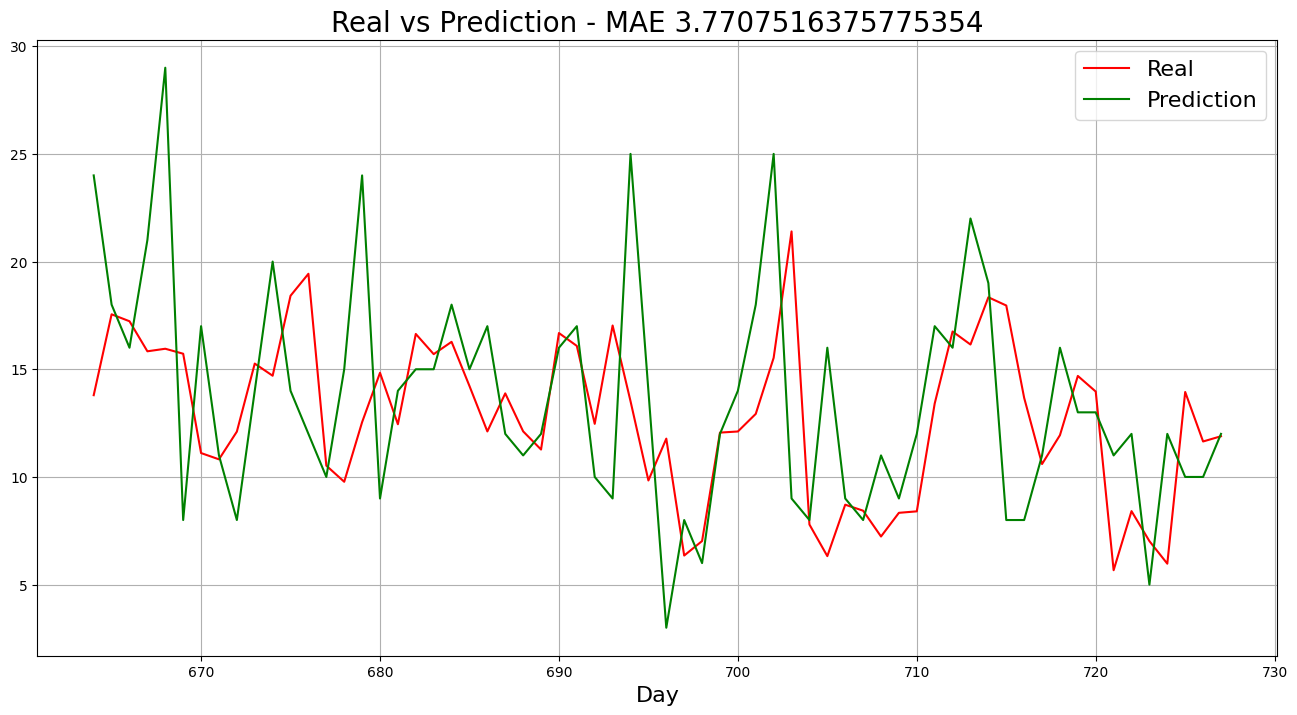

In [48]:
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(pd.Series(y_pred[:64], index=df_test[:64].index), color='red')
plt.plot(pd.Series(y_test[:64], index=df_test[:64].index), color='green')
plt.xlabel('Day', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

So there are results on the test set. We can visualize the most important features:

<AxesSubplot:title={'center':'Feature coefficients'}>

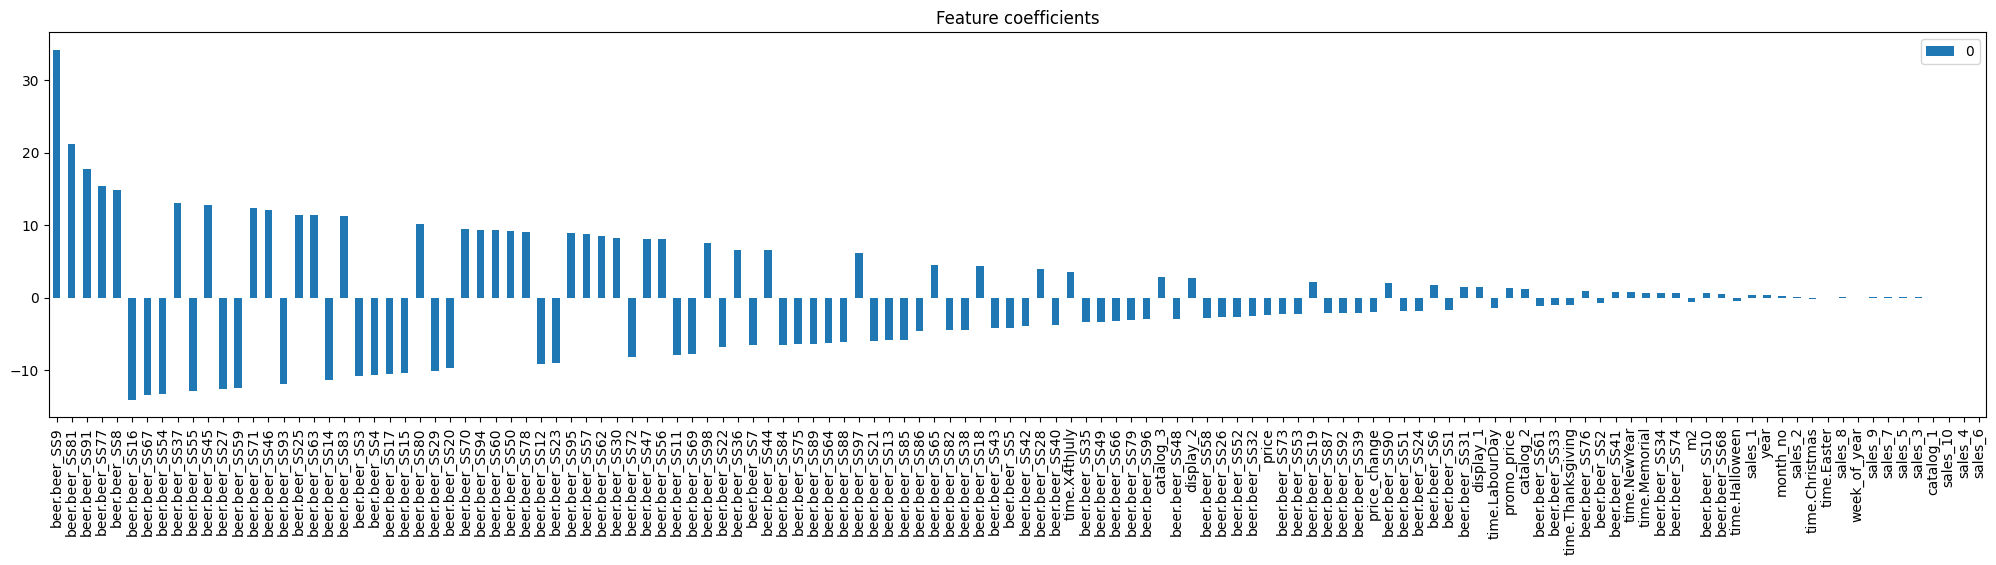

In [49]:
df_coeffs = pd.DataFrame(lr.coef_, lr.feature_names_in_).sort_values(by=0, key=abs, ascending=False)
df_coeffs.plot(kind='bar', figsize=(25, 5), title='Feature coefficients')

As we can see, the most important features, except for product names, are catalog_3, 4th July, price_change, display_2, promo_price and Labour Day; some of them raise demand and some reduce.   
Now we can calculate price elasticity with the formula: `Coefficient (Slope) * Price mean / Quantity mean`

In [50]:
slope = lr.coef_[1]
slope

-2.3277101805825207

In [51]:
mean_price = df_train.groupby('product')['price'].mean()
mean_price

product
beer.beer_SS1      7.323343
beer.beer_SS10     8.495437
beer.beer_SS11     3.507787
beer.beer_SS12     3.483693
beer.beer_SS13     5.085000
                    ...    
beer.beer_SS94    12.910228
beer.beer_SS95    12.125317
beer.beer_SS96     7.085574
beer.beer_SS97    11.216410
beer.beer_SS98    12.220423
Name: price, Length: 98, dtype: float64

In [52]:
mean_quantity = df_train.groupby('product')['salesQ'].mean()
mean_quantity

product
beer.beer_SS1      9.084746
beer.beer_SS10     5.432203
beer.beer_SS11    17.141243
beer.beer_SS12    11.327586
beer.beer_SS13     8.748276
                    ...    
beer.beer_SS94     9.502825
beer.beer_SS95     4.214689
beer.beer_SS96     3.686441
beer.beer_SS97     4.610169
beer.beer_SS98     3.183616
Name: salesQ, Length: 98, dtype: float64

In [53]:
price_elasticity = slope * mean_price / mean_quantity
price_elasticity

product
beer.beer_SS1    -1.876400
beer.beer_SS10   -3.640312
beer.beer_SS11   -0.476343
beer.beer_SS12   -0.715865
beer.beer_SS13   -1.352999
                    ...   
beer.beer_SS94   -3.162351
beer.beer_SS95   -6.696632
beer.beer_SS96   -4.474008
beer.beer_SS97   -5.663252
beer.beer_SS98   -8.934999
Length: 98, dtype: float64

<AxesSubplot:xlabel='product'>

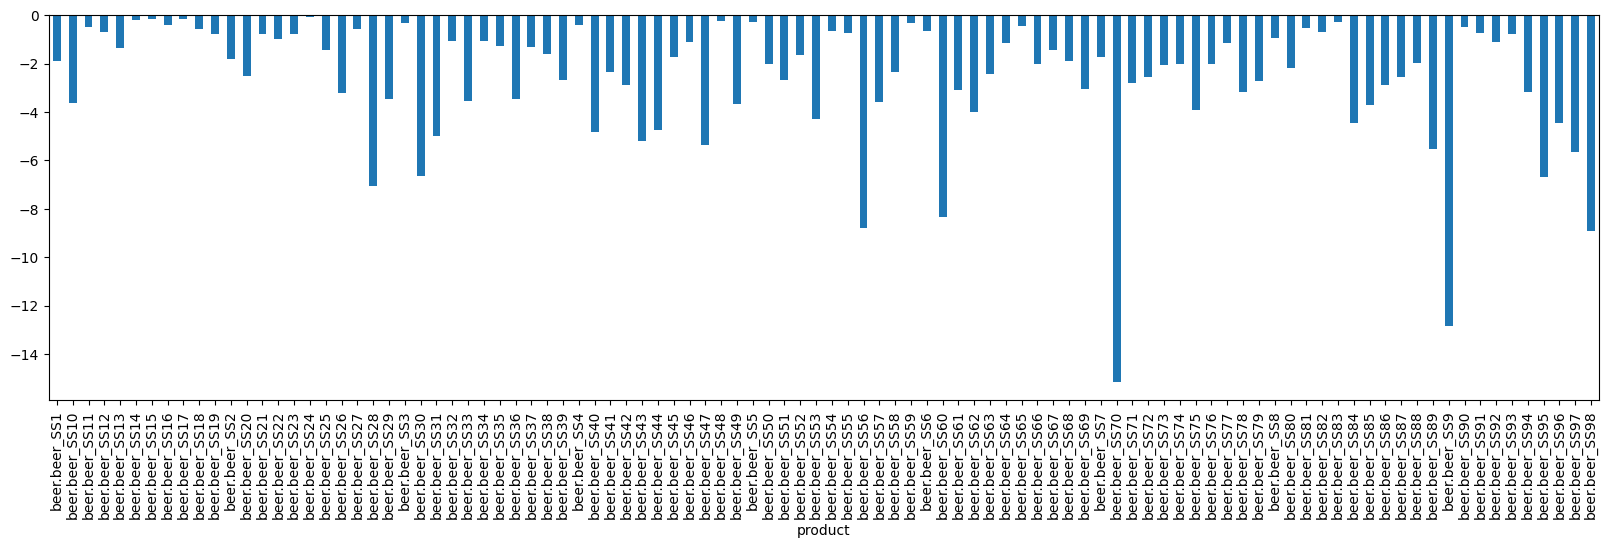

In [54]:
price_elasticity.plot(kind='bar', figsize=(20, 5))

In [55]:
price_elasticity.mean()

-2.6486408608369074

Now I'd like to try XGBoost model

In [56]:
from xgboost import XGBRegressor, DMatrix, train

In [57]:
matrix_train = DMatrix(X_train, label=y_train)
matrix_val = DMatrix(X_val, label=y_val)
matrix_test = DMatrix(X_test)

In [58]:
model = train(params={'objective': 'reg:linear', 'eval_metric': ['mae', 'rmse']}, dtrain=matrix_train, num_boost_round=500, early_stopping_rounds=20, evals=[(matrix_val, 'val')])

[19:08:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	val-mae:8.68237	val-rmse:14.80315
[1]	val-mae:6.50641	val-rmse:11.51585
[2]	val-mae:5.26087	val-rmse:9.45897
[3]	val-mae:4.59547	val-rmse:8.21590
[4]	val-mae:4.24433	val-rmse:7.44700
[5]	val-mae:4.07592	val-rmse:6.97934
[6]	val-mae:3.98160	val-rmse:6.70328
[7]	val-mae:3.93987	val-rmse:6.55889
[8]	val-mae:3.91508	val-rmse:6.44751
[9]	val-mae:3.90375	val-rmse:6.36887
[10]	val-mae:3.89076	val-rmse:6.32296
[11]	val-mae:3.87989	val-rmse:6.27738
[12]	val-mae:3.86729	val-rmse:6.24010
[13]	val-mae:3.86309	val-rmse:6.22510
[14]	val-mae:3.86161	val-rmse:6.21592
[15]	val-mae:3.85671	val-rmse:6.20699
[16]	val-mae:3.84499	val-rmse:6.19728
[17]	val-mae:3.84022	val-rmse:6.18065
[18]	val-mae:3.83029	val-rmse:6.16415
[19]	val-mae:3.83042	val-rmse:6.15889
[20]	val-mae:3.82

In [59]:
y_pred = model.predict(matrix_test)

In [60]:
mae = mean_absolute_error(y_pred, y_test)

Now we got a bit better result; it shows the advanages of the boosting model.

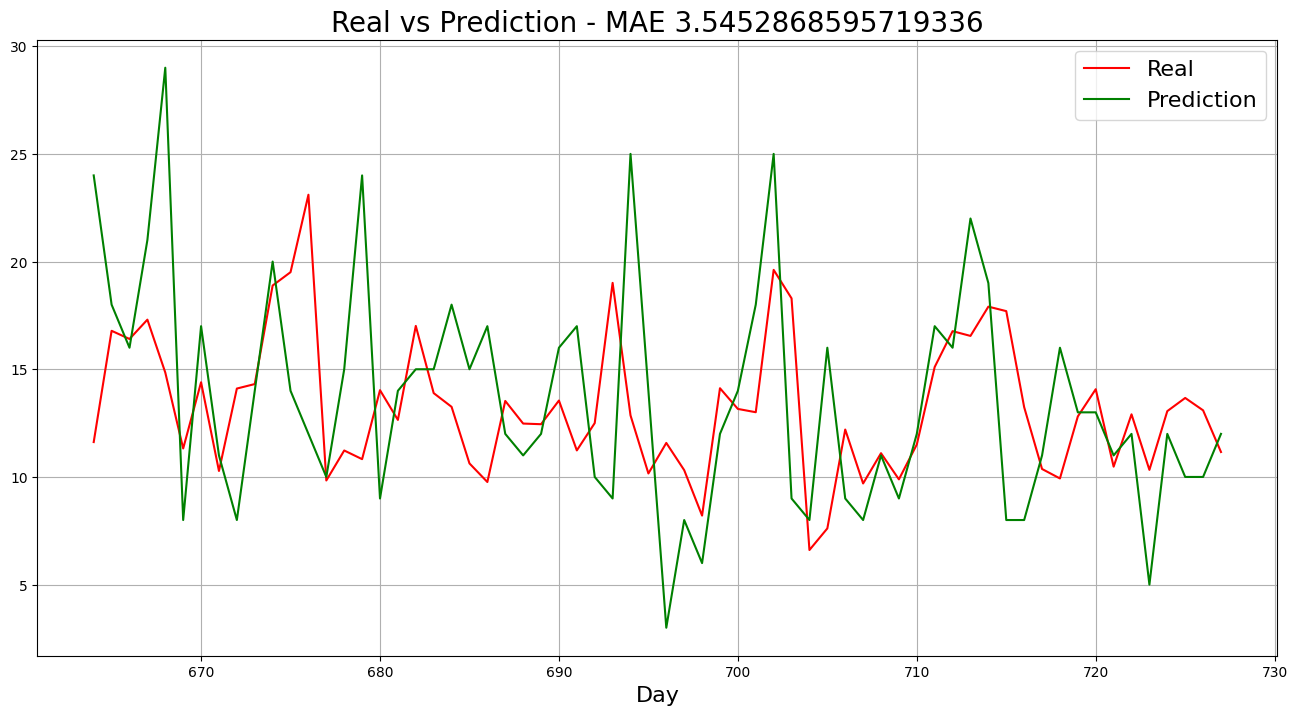

In [61]:
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(pd.Series(y_pred[:64], index=df_test[:64].index), color='red')
plt.plot(pd.Series(y_test[:64], index=df_test[:64].index), color='green')
plt.xlabel('Day', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()